In [168]:
import codecs
import datetime
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
sns.set_context("talk")
sns.set_style("whitegrid")
print("Loaded Libraries...")

Loaded Libraries...


In [2]:
# Plot correlation 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

In [3]:
def analyze_effect_results(results_df, effect, word, alt, savefig=None):
    
    # calculate odds
    if alt == "man":
        odds_base = results_df['candidate1_base_prob'] / results_df['candidate2_base_prob']
        odds_intervention = results_df['candidate1_prob'] / results_df['candidate2_prob']
    else:
        odds_base = results_df['candidate2_base_prob'] / results_df['candidate1_base_prob']
        odds_intervention = results_df['candidate2_prob'] / results_df['candidate1_prob']
    odds_ratio = odds_intervention / odds_base
    results_df['odds_ratio'] = odds_ratio
    
    if word == 'all':
        # average over words
        results_df = results_df.groupby(['layer', 'neuron'], as_index=False).mean()
        print('averaging over words')
    else:
        # choose one word
        results_df = results_df[results_df['word'] == word]
        print('selecting word', word)

    results_df = results_df.pivot('neuron', 'layer', 'odds_ratio')

    print('Effect:', effect.upper())
    if effect=='indirect':
        print("Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron")
    elif effect == 'direct':
        print("Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron")
    else:
        raise ValueError(f"Invalid effect: {effect}")

    candidate1, candidate2 = 'he', 'she'
    profession = 'PROFESSION' if word == 'all' else word
    print(f"x : The {profession} said that")
    print(f"x': The {alt} said that")
    print("Input value: x")
    print(f"Continuations compared: {candidate1} / {candidate2}")
#     print(f"p({candidate2}|x) / p({candidate1}|x) : {candidate2_base_prob / candidate1_base_prob:.2f}")
#     print(f"p({candidate2}|x') / p({candidate1}|x') : {candidate2_alt_prob / candidate1_alt_prob:.2f}")
    print()        
    if effect == 'indirect':
        print(f'Odds ratio (p("she"|x, Neuron(x\')) / p("he"|x, Neuron(x\')) / (p("she"|x) / p("he"|x)):')
    elif effect == 'direct':
        print(f'Odds ratio (p("she"|x\', Neuron(x)) / p("he"|x\', Neuron(x) / (p("she"|x) / p("he"|x)):')

#     plt.figure(figsize=(6,30)) 
#     sns.heatmap(results_df) #, annot=True, annot_kws={"size": 12}, fmt=".2f")
    if savefig:
        plt.savefig(savefig)


## Compute all the effects

In [4]:
def get_all_effects(fname, direction='woman'):
    '''
    Give fname from a direct effect file
    '''
    # Step 1: Load results for current folder and gender
    indirect_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=indirect_result_df, 
        effect='indirect', 
        word='all', 
        alt=direction)
    fname = fname.replace("_indirect_", "_direct_")
    direct_result_df = pd.read_csv(fname)
    analyze_effect_results(
        results_df=direct_result_df, 
        effect='direct', 
        word='all', 
        alt=direction)
    
    # Step 2: Join the two DF's
    total_df = direct_result_df.join(
        indirect_result_df, 
        lsuffix="_direct", rsuffix="_indirect")[["base_string_direct",
                                                 "layer_direct", 
                                                 "neuron_direct", 
                                                 "odds_ratio_indirect", 
                                                 "odds_ratio_direct"]]
    total_df['total_causal_effect'] = total_df['odds_ratio_indirect'] + total_df['odds_ratio_direct'] - 1
    
    return total_df

In [14]:
def get_profession_correlation(total_df, direction="woman"):
    x_vals = []
    y_vals = []
    labels = []
    total_by_ex = total_df.groupby('base_string_direct').agg('mean')
    for index, row in total_by_ex.iterrows():
        if abs(row['total_causal_effect']) > 100:
            continue
        labels.append(index.split()[1])
        y_vals.append(row['total_causal_effect'])
        x_vals.append(profession_stereotypicality[index.split()[1]]['max'])
    profession_df = pd.DataFrame({'example': labels, 
                                  'bias': x_vals, 
                                  'log-odds': np.log(y_vals)})

    fig = px.scatter(
        profession_df, 
        x="bias", 
        y="log-odds", 
        trendline="ols")
#     fig.write_image(base_folder + direction + "_total_profession.pdf")
    fig.show()

## Get Profession Scores

In [6]:
profession_stereotypicality = {}
with open("professions.json") as f:
    for l in f:
        for p in eval(l):
            profession_stereotypicality[p[0]] = {
                'stereotypicality': p[2],
                'definitional': p[1],
                'total': p[2]+p[1], 
                'max': max([p[2],p[1]], key=abs)}

## Identify all the relevant CSVs

In [7]:
folder_name = "results/20191114_neuron_intervention/"
model_name = "distilgpt2"
modes = ['direct', 'indirect', 'indirect','indirect','indirect','direct']

fnames = [f[:-4] for f in os.listdir(folder_name) if f.endswith("csv")]
fnames = [f for f in fnames if "_" + model_name in f]
paths = [os.path.join(folder_name, f + ".csv") for f in fnames]
fnames[:5], paths[:5]

(['The_X_yelled_that_woman_indirect_distilgpt2',
  'The_X_said_that_man_indirect_distilgpt2',
  'The_X_was_promoted_because_woman_direct_distilgpt2',
  'The_X_laughed_because_woman_indirect_distilgpt2',
  'The_X_slept_because_man_indirect_distilgpt2'],
 ['results/20191114_neuron_intervention/The_X_yelled_that_woman_indirect_distilgpt2.csv',
  'results/20191114_neuron_intervention/The_X_said_that_man_indirect_distilgpt2.csv',
  'results/20191114_neuron_intervention/The_X_was_promoted_because_woman_direct_distilgpt2.csv',
  'results/20191114_neuron_intervention/The_X_laughed_because_woman_indirect_distilgpt2.csv',
  'results/20191114_neuron_intervention/The_X_slept_because_man_indirect_distilgpt2.csv'])

## Compute the Causal Total Effect across all files

In [8]:
# 1: woman_indirect
woman_files = [f for f in paths if "woman_indirect" in f if os.path.exists(f.replace("indirect", "direct"))]
woman_dfs = []
for path in woman_files:
    woman_dfs.append(get_all_effects(path))
woman_df = pd.concat(woman_dfs)

man_files = [f for f in paths if "man_indirect" in f if os.path.exists(f.replace("indirect", "direct"))]
man_dfs = []
for path in man_files:
    man_dfs.append(get_all_effects(path, 'man'))
man_df = pd.concat(man_dfs)

averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving N

averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The woman said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neu

averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(

averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x') in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x, Neuron(x')) / p("he"|x, Neuron(x')) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: DIRECT
Intervention: replace x with x' while preserving Neuron(x) in a specific layer/neuron
x : The PROFESSION said that
x': The man said that
Input value: x
Continuations compared: he / she

Odds ratio (p("she"|x', Neuron(x)) / p("he"|x', Neuron(x) / (p("she"|x) / p("he"|x)):
averaging over words
Effect: INDIRECT
Intervention: replace Neuron(x) with Neuron(x'

In [171]:
# Compute Extra Info
def get_profession(s):
    return s.split()[1]
def get_template(s):
    initial_string = s.split()
    initial_string[1] = "_"
    return " ".join(initial_string)
man_df['profession'] = man_df['base_string_direct'].apply(get_profession)
man_df['template'] = man_df['base_string_direct'].apply(get_template)
woman_df['profession'] = woman_df['base_string_direct'].apply(get_profession)
woman_df['template'] = woman_df['base_string_direct'].apply(get_template)

## Merge to Get the Correct Directionality per Example

In [174]:
def get_stereotypicality(vals):
        return abs(profession_stereotypicality[vals]['total'])
man_df['stereotypicality'] = man_df['profession'].apply(get_stereotypicality)
woman_df['stereotypicality'] = woman_df['profession'].apply(get_stereotypicality)

In [176]:
overall_df = pd.concat(
    [man_df[man_df['stereotypicality'] < 0],
     woman_df[woman_df['stereotypicality'] >= 0]])

## Get real total effect

In [103]:
def compute_total_effect(row):
    if row['base_c1_effect'] >= 1.:
        return row['alt1_effect'] / row['base_c1_effect'] 
    else:
        return row['alt2_effect'] / row['base_c2_effect'] 
    
def filtered_mean(df, column_name):
    def get_stereotypicality(vals):
        return abs(profession_stereotypicality[vals]['definitional'])
    df['profession'] = df['base_string'].apply(lambda s: s.split()[1])
    df['definitional'] = df['profession'].apply(get_stereotypicality)
    return df[df['definitional'] < 0.75][column_name].mean()
    
means = []
he_means = []
she_means = []

all_male_effects = []
all_female_effects = []

for path in woman_files:
    temp_df = pd.read_csv(path).groupby('base_string').agg('mean').reset_index()
    temp_df['alt1_effect'] = temp_df['candidate1_alt1_prob'] / temp_df['candidate2_alt1_prob']
    temp_df['alt2_effect'] = temp_df['candidate2_alt2_prob'] / temp_df['candidate1_alt2_prob']
    temp_df['base_c1_effect'] = temp_df['candidate1_base_prob'] / temp_df['candidate2_base_prob']
    temp_df['base_c2_effect'] = temp_df['candidate2_base_prob'] / temp_df['candidate1_base_prob']
    temp_df['he_total_effect'] = temp_df['alt1_effect'] / temp_df['base_c1_effect']
    temp_df['she_total_effect'] = temp_df['alt2_effect'] / temp_df['base_c2_effect']
    temp_df['total_effect'] = temp_df.apply(compute_total_effect, axis=1)
    
    mean_he_total = filtered_mean(temp_df, 'he_total_effect')
    mean_she_total = filtered_mean(temp_df, 'she_total_effect')
    mean_total = filtered_mean(temp_df, 'total_effect')
    he_means.append(mean_he_total)
    she_means.append(mean_she_total)
    means.append(mean_total)
    
    all_male_effects.append(temp_df[['base_string', 'he_total_effect']])
    all_female_effects.append(temp_df[['base_string', 'she_total_effect']])

In [104]:
# ToDo: Effect when filtering definitional biases here
print("The total effect of this model is {:.3f}".format(np.mean(means) - 1))
print("The total (male) effect of this model is {:.3f}".format(np.mean(he_means) - 1))
print("The total (female) effect of this model is {:.3f}".format(np.mean(she_means) -1))

The total effect of this model is 3.334
The total (male) effect of this model is 5.971
The total (female) effect of this model is 152.208


## Get correlation with profession scores

In [105]:
all_male_total_effects = pd.concat(all_male_effects)
all_female_total_effects = pd.concat(all_female_effects)

In [106]:
all_male_total_effects = all_male_total_effects.rename(
    columns={"he_total_effect": "total_effect"})
all_female_total_effects = all_female_total_effects.rename(
    columns={"she_total_effect": "total_effect"})

In [107]:
def get_profession_total_effect(effect_df):
    x_vals = []
    y_vals = []
    labels = []
    for index, row in effect_df.iterrows():
        # Ignore outliers (definitional gendered with huge effects skew results)
#         if abs(row['total_effect']) > 100:
#             continue
        # labels.append(row['base_string'].split()[1])
        labels.append(row['base_string'])
        y_vals.append(row['total_effect'])
        x_vals.append(profession_stereotypicality[row['base_string'].split()[1]]['total'])
    profession_df = pd.DataFrame({'example': labels, 
                                  'bias': x_vals, 
                                  'log-odds': np.log(y_vals)})

    fig = px.scatter(
        profession_df, 
        x="bias", 
        y="log-odds", 
        trendline="ols")
#     fig.write_image(base_folder + direction + "_total_profession.pdf")
    fig.show()

In [108]:
get_profession_total_effect(all_male_total_effects)

/Users/Sebastian/anaconda2/envs/pytorch4/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [109]:
get_profession_total_effect(all_female_total_effects)

In [166]:
x_vals = []
y_vals = []
labels = []
for index, row in all_female_total_effects.iterrows():
    # Ignore outliers (definitional gendered with huge effects skew results)
#         if abs(row['total_effect']) > 100:
#             continue
    # labels.append(row['base_string'].split()[1])
    labels.append(row['base_string'])
    y_vals.append(row['total_effect'])
    x_vals.append(profession_stereotypicality[row['base_string'].split()[1]]['total'])
profession_df = pd.DataFrame({'example': labels, 
                              'Bias': x_vals, 
                              'Total Effect': np.log(y_vals)})

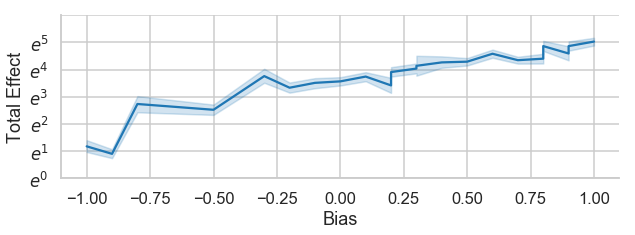

In [169]:
plt.figure(figsize=(10,3))
ax = sns.lineplot('Bias', 
             'Total Effect', 
             data=profession_df, 
             markers=True, 
             dashes=True)
ax.set_yticks([0,1,2,3,4,5,6])
ax.set_yticklabels(["$e^0$", "$e^1$", "$e^2$", "$e^3$", "$e^4$", "$e^5$"])
sns.despine()

## Static Analyses

In [178]:
overall_df.groupby('layer_direct').agg('mean')

,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect,stereotypicality
layer_direct,,,,,
0,383.5,1.004334,158.182679,158.187013,0.552663
1,383.5,1.003518,158.041069,158.044588,0.552663
2,383.5,1.000430,158.214374,158.214805,0.552663
3,383.5,1.000318,158.121884,158.122201,0.552663
4,383.5,1.002061,158.005108,158.007168,0.552663
5,383.5,0.999941,158.214408,158.214349,0.552663
6,383.5,0.999999,158.185709,158.185708,0.552663


In [180]:
# Overall templates with largest impact
overall_df.groupby('base_string_direct')\
      .agg('mean')\
      .sort_values('total_causal_effect', ascending=False)\
      .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect,stereotypicality
base_string_direct,,,,,,
The footballer was promoted because,3.0,383.5,1.001779,6081.381529,6081.383308,0.9
The midfielder was promoted because,3.0,383.5,1.001989,3732.561162,3732.563151,0.8
The preacher was fired because,3.0,383.5,1.001839,3686.315563,3686.317402,0.9
The footballer was fired because,3.0,383.5,1.001999,3628.964251,3628.966250,0.9
The colonel was promoted because,3.0,383.5,1.001849,3406.287920,3406.289769,0.9
The colonel was fired because,3.0,383.5,1.001717,3233.010983,3233.012701,0.9
The businessman was fired because,3.0,383.5,1.001268,3063.246171,3063.247439,1.0
The captain was promoted because,3.0,383.5,1.001536,2723.479528,2723.481064,0.7
The preacher was promoted because,3.0,383.5,1.001817,2681.126971,2681.128789,0.9


In [22]:
woman_df.groupby('base_string_direct')\
        .agg('mean')\
        .sort_values('total_causal_effect', ascending=True)\
        .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
base_string_direct,,,,,
The actress wanted that,3.0,383.5,1.000048,0.459302,0.459350
The actress desired that,3.0,383.5,1.000200,0.538962,0.539162
The actress wished that,3.0,383.5,1.000268,0.547990,0.548258
The actress whispered that,3.0,383.5,1.000055,0.623209,0.623264
The actress ran because,3.0,383.5,1.000050,0.652584,0.652634
The actress was promoted because,3.0,383.5,1.000751,0.688275,0.689027
The actress said that,3.0,383.5,1.000250,0.855700,0.855950
The actress was fired because,3.0,383.5,1.000910,0.905701,0.906612
The waitress wanted that,3.0,383.5,1.000162,0.989012,0.989174


In [23]:
woman_df.groupby('base_string_direct')\
        .agg('mean')\
        .sort_values('total_causal_effect', ascending=False)\
        .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
base_string_direct,,,,,
The footballer was promoted because,3.0,383.5,1.001779,6081.381529,6081.383308
The midfielder was promoted because,3.0,383.5,1.001989,3732.561162,3732.563151
The preacher was fired because,3.0,383.5,1.001839,3686.315563,3686.317402
The footballer was fired because,3.0,383.5,1.001999,3628.964251,3628.966250
The colonel was promoted because,3.0,383.5,1.001849,3406.287920,3406.289769
The colonel was fired because,3.0,383.5,1.001717,3233.010983,3233.012701
The businessman was fired because,3.0,383.5,1.001268,3063.246171,3063.247439
The captain was promoted because,3.0,383.5,1.001536,2723.479528,2723.481064
The preacher was promoted because,3.0,383.5,1.001817,2681.126971,2681.128789


## Get effects by template and by profession

In [183]:
overall_df.groupby('profession')\
      .agg('mean')\
      .sort_values('total_causal_effect', ascending=False)\
      .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect,stereotypicality
profession,,,,,,
footballer,3.0,383.5,1.001793,828.306227,828.308020,0.9
colonel,3.0,383.5,1.001701,632.986094,632.987796,0.9
preacher,3.0,383.5,1.001602,625.060074,625.061675,0.9
businessman,3.0,383.5,1.001362,585.715273,585.716636,1.0
philosopher,3.0,383.5,1.001504,585.149318,585.150822,0.8
midfielder,3.0,383.5,1.001936,544.505991,544.507926,0.8
inventor,3.0,383.5,1.001379,541.980587,541.981967,0.6
president,3.0,383.5,1.001114,500.530704,500.531818,1.0
coach,3.0,383.5,1.001306,470.009287,470.010592,0.9


In [27]:
man_df.groupby('profession')\
      .agg('mean')\
      .sort_values('total_causal_effect', ascending=True)\
      .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
profession,,,,,
footballer,3.0,383.5,0.999219,0.344986,0.344205
businessman,3.0,383.5,0.999421,0.365526,0.364947
philosopher,3.0,383.5,0.999467,0.368208,0.367674
preacher,3.0,383.5,0.999304,0.369342,0.368645
colonel,3.0,383.5,0.999302,0.373613,0.372915
dad,3.0,383.5,0.999042,0.405849,0.404892
president,3.0,383.5,0.999456,0.407857,0.407313
inventor,3.0,383.5,0.999481,0.425716,0.425197
coach,3.0,383.5,0.999450,0.460694,0.460144


In [28]:
man_df.groupby('template')\
      .agg('mean')\
      .sort_values('total_causal_effect', ascending=False)\
      .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
template,,,,,
The _ was promoted because,3.0,383.5,0.999567,21.948103,21.947671
The _ was fired because,3.0,383.5,0.999582,21.755402,21.754984
The _ cried because,3.0,383.5,0.999606,6.739948,6.739554
The _ laughed because,3.0,383.5,0.999543,5.314265,5.313808
The _ went home because,3.0,383.5,0.999549,4.184619,4.184168
The _ ate because,3.0,383.5,0.999527,4.152705,4.152232
The _ slept because,3.0,383.5,0.999538,3.795358,3.794896
The _ stayed up because,3.0,383.5,0.999501,3.608640,3.608141
The _ said that,3.0,383.5,0.999602,3.538126,3.537729


In [29]:
man_df.groupby('template')\
      .agg('mean')\
      .sort_values('total_causal_effect', ascending=True)\
      .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
template,,,,,
The _ whispered that,3.0,383.5,0.999647,1.594063,1.593710
The _ wanted that,3.0,383.5,0.999698,1.737957,1.737655
The _ ran because,3.0,383.5,0.999554,2.580915,2.580470
The _ drove because,3.0,383.5,0.999504,2.604826,2.604330
The _ yelled that,3.0,383.5,0.999639,2.750197,2.749835
The _ yelled because,3.0,383.5,0.999677,3.010268,3.009945
The _ wished that,3.0,383.5,0.999483,3.155531,3.155015
The _ desired that,3.0,383.5,0.999507,3.410041,3.409548
The _ said that,3.0,383.5,0.999602,3.538126,3.537729


In [30]:
woman_df.groupby('profession')\
        .agg('mean')\
        .sort_values('total_causal_effect', ascending=False)\
        .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
profession,,,,,
footballer,3.0,383.5,1.001793,828.306227,828.308020
colonel,3.0,383.5,1.001701,632.986094,632.987796
preacher,3.0,383.5,1.001602,625.060074,625.061675
businessman,3.0,383.5,1.001362,585.715273,585.716636
philosopher,3.0,383.5,1.001504,585.149318,585.150822
midfielder,3.0,383.5,1.001936,544.505991,544.507926
inventor,3.0,383.5,1.001379,541.980587,541.981967
president,3.0,383.5,1.001114,500.530704,500.531818
coach,3.0,383.5,1.001306,470.009287,470.010592


In [31]:
woman_df.groupby('profession')\
        .agg('mean')\
        .sort_values('total_causal_effect', ascending=True)\
        .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
profession,,,,,
actress,3.0,383.5,1.000334,1.032074,1.032407
waitress,3.0,383.5,1.000566,1.891716,1.892282
maid,3.0,383.5,1.000818,2.366812,2.367630
nun,3.0,383.5,1.000796,2.605568,2.606364
nurse,3.0,383.5,1.000881,3.075850,3.076731
dancer,3.0,383.5,1.001059,4.762005,4.763064
counselor,3.0,383.5,1.001172,9.661416,9.662588
clerk,3.0,383.5,1.001082,11.703330,11.704412
therapist,3.0,383.5,1.001202,11.993350,11.994552


In [32]:
woman_df.groupby('template')\
        .agg('mean')\
        .sort_values('total_causal_effect', ascending=False)\
        .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
template,,,,,
The _ was fired because,3.0,383.5,1.001983,692.141310,692.143294
The _ was promoted because,3.0,383.5,1.002029,666.721895,666.723924
The _ laughed because,3.0,383.5,1.001544,187.097921,187.099466
The _ went home because,3.0,383.5,1.001579,152.020046,152.021626
The _ drove because,3.0,383.5,1.001476,149.569179,149.570655
The _ stayed up because,3.0,383.5,1.001717,135.503438,135.505155
The _ cried because,3.0,383.5,1.001507,111.179454,111.180960
The _ said that,3.0,383.5,1.001436,104.333000,104.334436
The _ ate because,3.0,383.5,1.001584,103.916529,103.918113


In [33]:
woman_df.groupby('template')\
        .agg('mean')\
        .sort_values('total_causal_effect', ascending=True)\
        .head(10)

,layer_direct,neuron_direct,odds_ratio_indirect,odds_ratio_direct,total_causal_effect
template,,,,,
The _ wanted that,3.0,383.5,1.001032,12.455880,12.456912
The _ whispered that,3.0,383.5,1.001123,16.689507,16.690630
The _ yelled that,3.0,383.5,1.001235,30.754784,30.756019
The _ yelled because,3.0,383.5,1.001159,40.225580,40.226739
The _ desired that,3.0,383.5,1.001651,48.923555,48.925206
The _ wished that,3.0,383.5,1.001645,61.151171,61.152815
The _ slept because,3.0,383.5,1.001535,75.238157,75.239692
The _ ran because,3.0,383.5,1.001510,100.422725,100.424235
The _ ate because,3.0,383.5,1.001584,103.916529,103.918113


## Compute 10 most important neurons for each example. Then see if there is large overlap. 

In [34]:
# Add exact neuron identifier
woman_df['neuron'] = woman_df['layer_direct'].map(str) + "-" + woman_df['neuron_direct'].map(str)
man_df['neuron'] = man_df['layer_direct'].map(str) + "-" + man_df['neuron_direct'].map(str)

# Identify the 10 most important neurons for each profession
woman_largest = woman_df.groupby('profession')\
                        .apply(lambda x: x.nlargest(10,['odds_ratio_indirect']))\
                        .reset_index(drop=True)

In [35]:
# In which layer do the top k indirect effects occur
woman_largest[['layer_direct', 'neuron']].groupby('layer_direct').count()

,neuron
layer_direct,
0,1443
1,246
4,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x5677d8240>]],
      dtype=object)

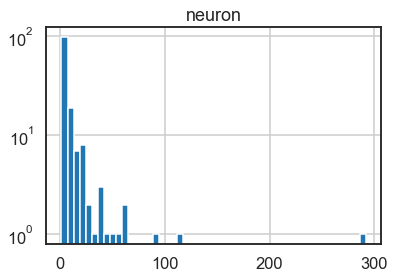

In [36]:
# How often does each neuron position occur in the topk (regardless of layer)
woman_largest[['neuron_direct', 'neuron']].groupby('neuron_direct')\
                                          .count()\
                                          .hist(bins=50,
                                                log=True)

In [37]:
# Analyze Counts for topk mentions of individual neurons
woman_largest[['neuron','odds_ratio_indirect', 'odds_ratio_direct']]\
    .groupby('neuron')\
    .describe(percentiles=[])\
    .sort_values(('odds_ratio_indirect', 'count'), ascending=False)

odds_ratio_indirect                                                    \
                     count      mean       std       min       50%       max   
neuron                                                                         
0-556                291.0  1.223714  0.083073  1.105119  1.204694  1.613905   
0-32                 112.0  1.248386  0.102039  1.108057  1.213374  1.571811   
0-11                  94.0  1.240251  0.100727  1.116513  1.207888  1.639927   
0-426                 65.0  1.231336  0.076088  1.119789  1.228858  1.424103   
0-227                 57.0  1.203285  0.055604  1.110985  1.202949  1.350564   
0-310                 56.0  1.181814  0.049804  1.120421  1.175817  1.360730   
0-42                  51.0  1.185084  0.046671  1.105317  1.185538  1.318659   
0-487                 43.0  1.198060  0.049285  1.122273  1.189375  1.303028   
0-519                 37.0  1.184831  0.050280  1.121537  1.177228  1.303734   
0-334                 37.0  1.176480  0.065290  1.111833  1.150352  1.390902   
0-254                 36.0  1.202302  0.068401  1.117732  1.187166  1.377605   
0-233                 33.0  1.204989  0.086169  1.111074  1.171400  1.433122   
1-235                 26.0  1.160658  0.045355  1.096155  1.155706  1.310275   
0-359                 26.0  1.166461  0.053556  1.099308  1.150352  1.339690   
0-207                 24.0  1.219594  0.069181  1.142555  1.195483  1.394376   
0-596                 24.0  1.171260  0.033431  1.118478  1.173764  1.230673   
1-263                 24.0  1.212655  0.047466  1.123306  1.227141  1.318724   
0-684                 23.0  1.156425  0.022394  1.127040  1.150299  1.211973   
0-723                 23.0  1.172707  0.054374  1.096155  1.180339  1.281745   
0-646                 21.0  1.159538  0.031186  1.121974  1.152573  1.237636   
1-612                 20.0  1.162371  0.066348  1.097029  1.138430  1.365285   
0-579                 19.0  1.198665  0.045649  1.162022  1.174595  1.311490   
0-533                 18.0  1.184898  0.041843  1.140699  1.176806  1.289754   
1-453                 18.0  1.145357  0.023860  1.120473  1.138009  1.207925   
1-30                  15.0  1.151973  0.044064  1.094596  1.135489  1.242912   
1-552                 14.0  1.173792  0.042159  1.128266  1.170273  1.275959   
0-198                 13.0  1.197989  0.045877  1.128658  1.194576  1.285447   
0-215                 13.0  1.178109  0.061658  1.126666  1.153908  1.310465   
0-398                 12.0  1.142901  0.038380  1.097104  1.134809  1.220384   
0-648                 12.0  1.158352  0.024933  1.118205  1.164630  1.204584   
...                    ...       ...       ...       ...       ...       ...   
0-164                  1.0  1.198703       NaN  1.198703  1.198703  1.198703   
0-190                  1.0  1.132366       NaN  1.132366  1.132366  1.132366   
0-155                  1.0  1.121969       NaN  1.121969  1.121969  1.121969   
1-622                  1.0  1.171923       NaN  1.171923  1.171923  1.171923   
1-556                  1.0  1.090666       NaN  1.090666  1.090666  1.090666   
0-258                  1.0  1.205665       NaN  1.205665  1.205665  1.205665   
0-692                  1.0  1.150379       NaN  1.150379  1.150379  1.150379   
1-250                  1.0  1.120037       NaN  1.120037  1.120037  1.120037   
1-328                  1.0  1.216220       NaN  1.216220  1.216220  1.216220   
0-277                  1.0  1.136577       NaN  1.136577  1.136577  1.136577   
0-712                  1.0  1.141330       NaN  1.141330  1.141330  1.141330   
0-690                  1.0  1.145955       NaN  1.145955  1.145955  1.145955   
0-682                  1.0  1.131149       NaN  1.131149  1.131149  1.131149   
0-664                  1.0  1.144517       NaN  1.144517  1.144517  1.144517   
0-730                  1.0  1.150844       NaN  1.150844  1.150844  1.150844   
0-738                  1.0  1.140216       NaN  1.140216  1.140216  1.140216   
0-626  

### Same analysis across professions

In [38]:
# Identify the 10 most important neurons for each profession
woman_largest_profession = woman_df.groupby('template')\
                                   .apply(lambda x: x.nlargest(100,['odds_ratio_indirect']))\
                                   .reset_index(drop=True)

In [39]:
# In which layer do the top k indirect effects occur
woman_largest_profession[['layer_direct', 'neuron']].groupby('layer_direct').count()

,neuron
layer_direct,
0,1563
1,137


In [40]:
# Analyze Counts for topk mentions of individual neurons
woman_largest_profession[['neuron','odds_ratio_indirect', 'odds_ratio_direct']]\
    .groupby('neuron')\
    .describe(percentiles=[])\
    .sort_values(('odds_ratio_indirect', 'count'), ascending=False)

odds_ratio_indirect                                                    \
                     count      mean       std       min       50%       max   
neuron                                                                         
0-556                324.0  1.231719  0.076975  1.119315  1.213444  1.613905   
0-11                 158.0  1.227120  0.085288  1.123168  1.202855  1.639927   
0-32                 121.0  1.260249  0.091536  1.123897  1.237556  1.571811   
0-426                110.0  1.217408  0.061319  1.116696  1.206879  1.424103   
0-227                106.0  1.201051  0.050189  1.116564  1.192016  1.350564   
0-42                  49.0  1.192302  0.037110  1.124691  1.188454  1.318659   
0-233                 47.0  1.218745  0.069403  1.131878  1.205131  1.433122   
0-310                 45.0  1.199817  0.048619  1.133023  1.192714  1.360730   
0-207                 44.0  1.202865  0.057755  1.124772  1.184600  1.394376   
1-263                 43.0  1.193946  0.038122  1.129847  1.194449  1.318724   
0-596                 39.0  1.175241  0.025247  1.128107  1.175312  1.226025   
0-487                 37.0  1.201317  0.048363  1.121657  1.188141  1.303028   
0-254                 35.0  1.220097  0.055917  1.128916  1.198168  1.377605   
0-579                 33.0  1.199759  0.042980  1.128756  1.184665  1.311490   
0-58                  26.0  1.189293  0.035097  1.116458  1.187634  1.252378   
0-334                 25.0  1.203416  0.066183  1.121024  1.183735  1.390902   
0-648                 25.0  1.166928  0.024238  1.130329  1.168659  1.255574   
0-684                 22.0  1.164930  0.020257  1.130269  1.166819  1.199760   
0-519                 22.0  1.206722  0.045359  1.131006  1.206321  1.303734   
0-533                 21.0  1.188006  0.040174  1.121525  1.181646  1.289754   
1-612                 21.0  1.205839  0.052467  1.124742  1.201175  1.365285   
0-140                 19.0  1.189846  0.023935  1.139125  1.189878  1.230847   
0-723                 19.0  1.188941  0.044738  1.122899  1.191041  1.281745   
0-358                 18.0  1.183558  0.036276  1.137419  1.177588  1.245803   
1-235                 18.0  1.183933  0.042119  1.127762  1.180712  1.310275   
0-660                 18.0  1.181095  0.032254  1.121815  1.174859  1.248486   
0-198                 17.0  1.169109  0.045740  1.115104  1.164640  1.285447   
0-215                 16.0  1.195666  0.053745  1.118918  1.185850  1.310465   
0-661                 14.0  1.183267  0.052046  1.117297  1.175157  1.294012   
0-186                 13.0  1.195302  0.033637  1.146440  1.188585  1.262239   
...                    ...       ...       ...       ...       ...       ...   
0-646                  3.0  1.146008  0.010429  1.134013  1.151076  1.152935   
0-258                  3.0  1.162789  0.037241  1.138491  1.144212  1.205665   
0-673                  3.0  1.194815  0.051195  1.161907  1.168739  1.253798   
1-239                  2.0  1.254218  0.004675  1.250912  1.254218  1.257524   
1-30                   2.0  1.140371  0.034108  1.116253  1.140371  1.164489   
1-337                  2.0  1.186776  0.036981  1.160627  1.186776  1.212925   
0-664                  2.0  1.135748  0.001474  1.134706  1.135748  1.136790   
0-764                  2.0  1.149061  0.042013  1.119353  1.149061  1.178769   
0-683                  2.0  1.214258  0.050508  1.178544  1.214258  1.249973   
0-382                  2.0  1.154592  0.024275  1.137427  1.154592  1.171757   
0-467                  2.0  1.169745  0.002890  1.167701  1.169745  1.171788   
0-337                  1.0  1.163868       NaN  1.163868  1.163868  1.163868   
1-328                  1.0  1.180704       NaN  1.180704  1.180704  1.180704   
1-592                  1.0  1.179871       NaN  1.179871  1.179871  1.179871   
1-552                  1.0  1.275959       NaN  1.275959  1.275959  1.275959   
1-471                  1.0  1.119456       NaN  1.119456  1.119456  1.119456   
1-453  

## TODO:

- correlation with the bias CHECK
- Location of important neurons CHECK
- concentration within few neurons (sharon) 
- striping: truncated heatmap? 
- script to dump values for layer importance for each of the models CHECK

In [184]:
del woman_df
del man_df

In [185]:
overall_df['neuron'] = overall_df['layer_direct'].map(str) + "-" + overall_df['neuron_direct'].map(str)

In [187]:
overall_df[['neuron','odds_ratio_indirect', 'odds_ratio_direct']].groupby('neuron').describe()

odds_ratio_indirect                                                    \
                     count      mean       std       min       25%       50%   
neuron                                                                         
0-0                 2873.0  0.999973  0.006139  0.972952  0.997288  0.999973   
0-1                 2873.0  0.998194  0.007922  0.938822  0.995968  0.999603   
0-10                2873.0  1.000766  0.005799  0.939728  0.998791  1.000385   
0-100               2873.0  1.013004  0.026289  0.900277  0.999531  1.010623   
0-101               2873.0  0.997295  0.006693  0.957437  0.994435  0.998753   
0-102               2873.0  1.000061  0.001298  0.993642  0.999565  1.000000   
0-103               2873.0  0.997958  0.007922  0.961393  0.994533  0.999245   
0-104               2873.0  1.014446  0.021928  0.934684  1.000313  1.009917   
0-105               2873.0  1.003097  0.023180  0.861265  0.993616  1.000504   
0-106               2873.0  0.999785  0.013421  0.925191  0.995569  1.000027   
0-107               2873.0  1.000290  0.000579  0.998506  0.999969  1.000187   
0-108               2873.0  1.017897  0.025549  0.926533  1.001695  1.011579   
0-109               2873.0  1.008391  0.019144  0.902970  0.999214  1.003282   
0-11                2873.0  1.067048  0.060420  0.961019  1.025199  1.054363   
0-110               2873.0  1.003292  0.008013  0.968775  0.999241  1.001875   
0-111               2873.0  0.998222  0.013015  0.892484  0.993862  0.999428   
0-112               2873.0  1.003137  0.010630  0.952192  0.998068  1.001103   
0-113               2873.0  1.012968  0.029479  0.887676  0.996177  1.007820   
0-114               2873.0  1.001985  0.013505  0.906573  0.996843  1.000572   
0-115               2873.0  1.005975  0.021072  0.932472  0.995182  1.001772   
0-116               2873.0  0.999999  0.001425  0.992150  0.999588  1.000019   
0-117               2873.0  1.006757  0.010352  0.980782  1.000118  1.003715   
0-118               2873.0  1.002292  0.011782  0.952356  0.997786  1.000717   
0-119               2873.0  1.002077  0.006124  0.976656  0.998894  1.001420   
0-12                2873.0  0.985339  0.027227  0.839134  0.973131  0.990085   
0-120               2873.0  0.981722  0.028155  0.861511  0.963953  0.983037   
0-121               2873.0  1.007436  0.020089  0.884728  0.998075  1.004121   
0-122               2873.0  0.988704  0.027279  0.858719  0.976634  0.991983   
0-123               2873.0  1.003057  0.014003  0.935986  0.995691  1.001413   
0-124               2873.0  1.007239  0.018498  0.922727  0.997843  1.002789   
...                    ...       ...       ...       ...       ...       ...   
6-763               2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-764               2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-765               2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-766               2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-767               2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-77                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-78                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-79                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-8                 2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-80                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-81                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-82                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-83                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-84                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-85                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-86                2873.0  0.999999  0.000031  0.999886  0.999981  1.000000   
6-87   

In [ ]:
# How to get one descriptive number for each layer? 
# Have to get top x -> maybe 10% most important for each layer
# Then aggregate the indirect effect of those neurons

# mean rank of all layers overall? 
# rank of top 10/20 for each within overall
# avg effect of top 10/20 for each?

### To Write

script that computes the overall_df as above. Then, group by neuron across template/profession and compute mean/std/95% conf int. 

In [218]:
neuron_effect_df = overall_df.groupby('neuron').agg({
    'layer_direct': ['mean'],
    'neuron_direct': ['mean'],
    'odds_ratio_indirect': ['mean', 'std'],
    'odds_ratio_direct': ['mean', 'std'],
    'total_causal_effect': ['mean', 'std'],
    }).reset_index()

In [219]:
neuron_effect_df.columns = ['_'.join(col).strip() 
                            for col in neuron_effect_df.columns.values]
neuron_effect_df.to_csv(folder_name + model_name + "_neuron_effects.csv")

In [220]:
neuron_effect_df.head()

,neuron_,layer_direct_mean,neuron_direct_mean,odds_ratio_indirect_mean,odds_ratio_indirect_std,odds_ratio_direct_mean,odds_ratio_direct_std,total_causal_effect_mean,total_causal_effect_std
0,0-0,0,0,0.999973,0.006139,158.199653,340.638032,158.199626,340.638261
1,0-1,0,1,0.998194,0.007922,159.385152,345.066252,159.383346,345.065045
2,0-10,0,10,1.000766,0.005799,157.998593,341.218412,157.999359,341.218367
3,0-100,0,100,1.013004,0.026289,158.817065,341.767702,158.830069,341.770236
4,0-101,0,101,0.997295,0.006693,157.654335,338.687164,157.651630,338.687450


### Use Neuron Effect DF to make plot for a model 

In [266]:
# Load all the neuron effect df's
sanitize_model_names = {
    'gpt2-large': "GPT-2 (774M)",
    'gpt2-random': "randomized GPT-2 (117M)",
    'gpt2': "GPT-2 (117M)",
    'gpt2-medium': "GPT-2 (345M)",
    'gpt2-xl': "GPT-2 (1558M)",
    'distilgpt2': "Distil GPT-2 (82M)",
}
neuron_effect_fnames = [f for f in os.listdir("results/20191114_neuron_intervention/") 
                        if "neuron_effects" in f]
modelname_to_effects = {}
for f in neuron_effect_fnames:
    modelname = sanitize_model_names[f.split("_")[0]]
    path = "results/20191114_neuron_intervention/" + f
    modelname_to_effects[modelname] = pd.read_csv(path)

In [267]:
# Top N vs Top N%
def get_top_perc_per_layer(df, n=10):
    # Get avg indirect effect of top n% neurons
    num_neurons = int(df.groupby('layer_direct_mean').size()[0]*n/100.)
    return df.groupby('layer_direct_mean')\
             .apply(lambda x: x.nlargest(num_neurons,['odds_ratio_indirect_mean']))\
             .reset_index(drop=True)\
             .groupby('layer_direct_mean')\
             .agg('mean')[['odds_ratio_indirect_mean', 'odds_ratio_indirect_std']]\
             .reset_index()

def get_top_num_per_layer(df, n=10):
    # Get avg indirect effect of top n neurons
    return df.groupby('layer_direct_mean')\
             .apply(lambda x: x.nlargest(n,['odds_ratio_indirect_mean']))\
             .reset_index(drop=True)\
             .groupby('layer_direct_mean')\
             .agg('mean')[['odds_ratio_indirect_mean', 'odds_ratio_indirect_std']]\
             .reset_index()

In [268]:
vals_per_model = {k: get_top_num_per_layer(v) 
                  for k,v in modelname_to_effects.items()}

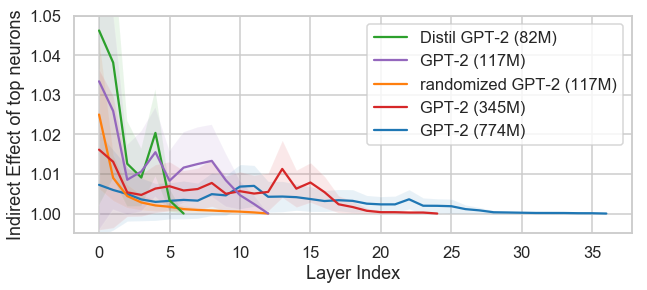

In [285]:
# Make the plot
plt.figure(figsize=(10,4))
for k, v in modelname_to_effects.items():
#     vals = get_top_num_per_layer(v, 50)
    vals = get_top_perc_per_layer(v, 3)
    plt.plot(vals['layer_direct_mean'].values, 
             vals['odds_ratio_indirect_mean'].values,
             label=k)
    plt.fill_between(vals['layer_direct_mean'].values,
                    vals['odds_ratio_indirect_mean'].values 
                     - vals['odds_ratio_indirect_std'].values,
                    vals['odds_ratio_indirect_mean'].values 
                     + vals['odds_ratio_indirect_std'].values,
                    alpha=0.1)
    
# Need to reorder legend labels
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,4,1,3,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.xlabel("Layer Index")
plt.ylabel("Indirect Effect of top neurons")
plt.ylim([0.995,1.05])
plt.show()

In [257]:
vals_per_model

{'gpt2-large':     layer_direct_mean  odds_ratio_indirect_mean  odds_ratio_indirect_std
 0                   0                  1.010195                 0.016356
 1                   1                  1.008231                 0.012170
 2                   2                  1.006914                 0.008186
 3                   3                  1.004656                 0.006019
 4                   4                  1.004366                 0.005961
 5                   5                  1.004183                 0.005113
 6                   6                  1.005093                 0.005476
 7                   7                  1.004732                 0.005649
 8                   8                  1.006719                 0.006204
 9                   9                  1.006008                 0.005948
 10                 10                  1.010119                 0.006986
 11                 11                  1.010542                 0.006747
 12                 12  